<a href="https://colab.research.google.com/github/Untick/InspectrumClinic_RecSys/blob/Andrey-Susarev-folder/Andrey-Susarev/Profpatolog_parsing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Грузим библиотеки
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Activation
!pip install keras-tuner --upgrade
from tensorflow.keras import utils
from keras_tuner.tuners import Hyperband, BayesianOptimization
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import statistics
import re
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import random
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from scipy import stats

%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 4.9 MB/s eta 0:00:00


In [ ]:
# и таблицу
# data = pd.read_excel('https://storage.yandexcloud.net/terratraineeship/23_InspectrumClinic_RS/datasets/%D0%B4%D0%B0%D1%82%D0%B0%D1%81%D0%B5%D1%82%20%D0%BF%D1%80%D0%BE%D1%84%D0%BF%D0%B0%D1%82%D0%BE%D0%BB%D0%BE%D0%B3%20%D1%87%D0%B0%D1%81%D1%82%D1%8C.xlsx')

In [ ]:
# Подключим диск
from google.colab import drive
drive.mount('/content/drive')

# и сохраним туда исходную таблицу
# data.to_excel('/content/drive/MyDrive/Стажировка/Profpatolog/Data/data_2.xlsx')

Mounted at /content/drive


In [ ]:
data = pd.read_excel('/content/drive/MyDrive/Стажировка/Profpatolog/Data/data_2.xlsx')

In [ ]:
# Смотрим структуру
print(data.shape)
print(data.info())
# print(data.head())
data.describe()

(1982, 4589)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1982 entries, 0 to 1981
Columns: 4589 entries, Unnamed: 0 to Возраст
dtypes: bool(1), datetime64[ns](43), float64(1337), int64(2), object(3206)
memory usage: 69.4+ MB
None


,Unnamed: 0,ЛабораторныеИсследования1_ХР_Рекомендация2Представление,ЛабораторныеИсследования1_ХР_РекомендацияСтр,Рентгенология1_ХР_Рекомендация1,Рентгенология1_ХР_Рекомендация1Представление,Рентгенология1_ХР_Рекомендация2,Рентгенология1_ХР_Рекомендация2Представление,Рентгенология1_ХР_РекомендацияСтр,Рентгенология2_ХР_Рекомендация1,Рентгенология2_ХР_Рекомендация1Представление,...,Оториноларингология3_Классификация11,Оториноларингология3_Классификация1Представление1,Оториноларингология3_Классификация21,Оториноларингология3_Классификация2Представление1,Оториноларингология3_Классификация31,Оториноларингология3_Классификация3Представление1,Оториноларингология3_Противопоказание1,Оториноларингология3_ПротивопоказаниеПредставление1,Оториноларингология3_Профессиональное1,Возраст
count,1982.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1982.000000
mean,990.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,40.666498
std,572.298436,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.566426
min,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,16.000000
25%,495.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,32.000000
50%,990.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,39.500000
75%,1485.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,50.000000
max,1981.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,71.000000


In [ ]:
# Вычислим возраст клиентов, результат запишим в отдельную колонку

data['Возраст'] = (data['ДатаЗавершенияМедосмотра'] - data['КлиентДатаРождения']).dt.days // 365

In [ ]:
# Посмотрим...
display(data.head())
data[['КлиентДатаРождения', 'ДатаЗавершенияМедосмотра', 'Возраст']].head()

,Unnamed: 0,ДокументПрохождениеМедосмотра,Клиент,КлиентДатаРождения,КлиентПол,КлиентПолПредставление,ДатаЗавершенияМедосмотра,ТипМедосмотра,ТипМедосмотраПредставление,ПсихОсвидетельствование,...,Оториноларингология3_Аудиометрия1_ЗначениеПредставление,Оториноларингология1_ЖалобыДополнение_Значение,Оториноларингология1_ЖалобыДополнение_ЗначениеПредставление,Стоматология2_ВП2_Значение,Стоматология2_ВП2_ЗначениеПредставление,Терапия2_ЗаключениеФОГК_Значение,Терапия2_ЗаключениеФОГК_ЗначениеПредставление,Офтальмология1_ДвигательныйАппаратГлазДополнение_Значение,Офтальмология1_ДвигательныйАппаратГлазДополнение_ЗначениеПредставление,Возраст
0,0,7f41ca7e-7dac-11ec-80fc-0cc47aab8067,c91e3407-b81f-11e9-80cf-0cc47aab8067,1976-10-24,Женский,Женский,2022-01-25,Периодический,Периодический,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,45
1,1,2ee1f9ac-83dd-11ec-80fc-0cc47aab8067,1a1a5fea-8b7f-11eb-80e8-0cc47aab8067,1987-11-18,Мужской,Мужской,2022-02-02,Периодический,Периодический,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34
2,2,9cbb191e-8e24-11ec-80fe-0cc47aab8067,7fe324e0-fa51-11eb-80f6-0cc47aab8067,1985-09-08,Мужской,Мужской,2022-02-15,Периодический,Периодический,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36
3,3,b8a33910-8eec-11ec-80fe-0cc47aab8067,98f9d761-8d65-11ec-80fe-0cc47aab8067,1988-04-25,Мужской,Мужской,2022-02-16,Периодический,Периодический,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,33
4,4,0bb0d181-938c-11ec-80fe-0cc47aab8067,009aac7d-7bcf-11eb-80e8-0cc47aab8067,1984-04-17,Мужской,Мужской,2022-02-22,Периодический,Периодический,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37


,КлиентДатаРождения,ДатаЗавершенияМедосмотра,Возраст
0,1976-10-24,2022-01-25,45
1,1987-11-18,2022-02-02,34
2,1985-09-08,2022-02-15,36
3,1988-04-25,2022-02-16,33
4,1984-04-17,2022-02-22,37


In [ ]:
df_cut = data.drop(data.select_dtypes(include=['bool']), axis=1)                                        # удаляем колонки с типом bool
df_cut = df_cut.loc[:, df_cut.isnull().mean() < 0.99]                                                   # удаляем "почти" пустые колонки
col_list = df_cut.columns.tolist()                                                                      # список столбцов
df_cut[col_list] = df_cut[col_list].astype(str).apply(lambda x: x.str.replace(r'\W+', '', regex=True))  # удаление служебных символов из столбцов
df_cut = df_cut.applymap(lambda x: x.lower() if type(x) == str else x)                                  # заменяем все заглавные буквы на прописные

In [ ]:
print(df_cut.info())
df_cut.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1982 entries, 0 to 1981
Columns: 1993 entries, Unnamed: 0 to Возраст
dtypes: object(1993)
memory usage: 30.1+ MB
None


,Unnamed: 0,ДокументПрохождениеМедосмотра,Клиент,КлиентДатаРождения,КлиентПол,КлиентПолПредставление,ДатаЗавершенияМедосмотра,ТипМедосмотра,ТипМедосмотраПредставление,Контрагент,...,Психиатрия2_ПсихическаяАктивность_ЗначениеПредставление,Психиатрия2_ПсихическаяАктивность2_Значение,Психиатрия2_ПсихическаяАктивность2_ЗначениеПредставление,Психиатрия2_МышлениеВ_Значение,Психиатрия2_МышлениеВ_ЗначениеПредставление,Психиатрия2_Интеллект_Значение,Психиатрия2_Интеллект_ЗначениеПредставление,Психиатрия2_ДанныхЗаНаркологическуюПатологиюНаМоментОсмотра_Значение,Психиатрия2_ДанныхЗаНаркологическуюПатологиюНаМоментОсмотра_ЗначениеПредставление,Возраст
0,0,7f41ca7e7dac11ec80fc0cc47aab8067,c91e3407b81f11e980cf0cc47aab8067,19761024000000,женский,женский,20220125000000,периодический,периодический,23c173a730d911e780d8708bcd7f83cd,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,45
1,1,2ee1f9ac83dd11ec80fc0cc47aab8067,1a1a5fea8b7f11eb80e80cc47aab8067,19871118000000,мужской,мужской,20220202000000,периодический,периодический,a6d559b0783511eb80e80cc47aab8067,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,34
2,2,9cbb191e8e2411ec80fe0cc47aab8067,7fe324e0fa5111eb80f60cc47aab8067,19850908000000,мужской,мужской,20220215000000,периодический,периодический,a6d559b0783511eb80e80cc47aab8067,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,36
3,3,b8a339108eec11ec80fe0cc47aab8067,98f9d7618d6511ec80fe0cc47aab8067,19880425000000,мужской,мужской,20220216000000,периодический,периодический,a6d559b0783511eb80e80cc47aab8067,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,33
4,4,0bb0d181938c11ec80fe0cc47aab8067,009aac7d7bcf11eb80e80cc47aab8067,19840417000000,мужской,мужской,20220222000000,периодический,периодический,a6d559b0783511eb80e80cc47aab8067,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,37


In [ ]:
# Cоздаем список с искомыми словами в названиях столбцов для последующего удаления
excluded_words = ['Представление', 'Документ', 'Контрагент', 'Врач', 'ЗаключениеМК', 'Салон', 'Дата']

# Формируем новую таблицу, удаляя столбцы из созданного списка
new_columns = [col for col in df_cut.columns if not any(word in col for word in excluded_words)]
new_df = df_cut[new_columns]
new_df.info()

# Также удалим столбцы "Клиент", "Unnamed: 0"
new_df=new_df.drop(columns=['Клиент', 'Unnamed: 0'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1982 entries, 0 to 1981
Columns: 921 entries, Unnamed: 0 to Возраст
dtypes: object(921)
memory usage: 13.9+ MB


In [ ]:
new_df.describe()

,КлиентПол,ТипМедосмотра,Цех,Профессия,Заключение,ДиспансернаяГруппа,ВредныеФакторы,ЛабораторныеИсследования1_Специализация,ЛабораторныеИсследования1_ОАК_Значение,ЛабораторныеИсследования1_Биохимия_Значение,...,Психиатрия2_Диагноз_Значение,Психиатрия2_БезСледовВВИнъекций_Значение,Психиатрия2_БезСледовСамопорезов_Значение,Психиатрия2_МышлениеКонкретное_Значение,Психиатрия2_ПсихическаяАктивность_Значение,Психиатрия2_ПсихическаяАктивность2_Значение,Психиатрия2_МышлениеВ_Значение,Психиатрия2_Интеллект_Значение,Психиатрия2_ДанныхЗаНаркологическуюПатологиюНаМоментОсмотра_Значение,Возраст
count,1982,1982,1982,1982,1982,1982,1982,1982,1982,1982,...,1982,1982,1982,1982,1982,1982,1982,1982,1982,1982
unique,2,2,182,588,13,8,514,4,2,2,...,2,2,2,2,2,2,2,2,2,54
top,мужской,периодический,nan,водитель,годенкработевуказанныхусловиях,i,23,e866ea50093d11e287b2002618dcef2c,получен,получен,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,36
freq,1451,1981,1180,64,1424,779,227,1652,1652,1655,...,1960,1960,1960,1960,1960,1960,1960,1960,1960,83


In [ ]:
# Сохраним на диск new_df: для экспериментов можно стартовать с этого места

# new_df.to_excel('/content/drive/MyDrive/Стажировка/Profpatolog/Data/new_df_modify_second.xlsx')
new_df = pd.read_excel('/content/drive/MyDrive/Стажировка/Profpatolog/Data/new_df_modify_second.xlsx')

In [ ]:
# Создадим словарь категориальных признаков "new_df"
dicts={}
for i in new_df.columns.values.tolist():
    if new_df[i].dtypes==object:
        c=0
        dl={}
        for j in new_df[i].unique():
            c+=1
            dl.update({j:c})
        dicts.update({i:dl})
# dict      
    

In [ ]:
# Соберем "таблицу категориальных признаков" на базе "new_df" и "dicts"
df_fl = new_df.copy()
for i in dicts.keys():
    for j in range(new_df[i].shape[0]):
        df_fl[i][j]=float(dicts.get(i).get(new_df[i][j]))

In [ ]:
# Преобразуем в тип float
df_fl=df_fl.astype(float)
# df_fl

In [ ]:
df_fl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1982 entries, 0 to 1981
Columns: 919 entries, КлиентПол to Возраст
dtypes: float64(919)
memory usage: 13.9 MB


In [ ]:
# Нормализуем данные в таблице признаков (кроме "Заключение")
for i in df_fl.columns.values.tolist():
   if i != 'Заключение':
        df_fl[i] = df_fl[i]/df_fl[i].max()

In [ ]:
# Сформируем массив данных и их значений
x=df_fl.drop(columns=['Заключение']).reset_index(drop=True)
y=df_fl['Заключение']
# x, y

In [ ]:
y.head()

0    1.0
1    1.0
2    2.0
3    1.0
4    2.0
Name: Заключение, dtype: float64

In [ ]:
# Разобъем массив на обучающую и тестовую выборки
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True)

In [ ]:
# Получение списка значений разницы между y_test и pred
def test_pred_diff_plot(test, pred, method):
    l_dl=[]
    print(method)
    for i in range(0, len(test)):
        print(test[i],pred[i], sep=' ')
        dif=(abs(test[i]-pred[i])/test[i])*100
        if dif != float("inf"):
            l_dl.append(dif)
    return l_dl

In [ ]:
def ml_method_estim(method_list,  x_train, x_test, y_train, y_test, plot=False):

    y_train=np.reshape(y_train.values, (-1,1))
    y_test=np.reshape(y_test.values, (-1,1))

    methods=[]
    MAE_list=[]
    R_2_list=[]
    MSE_list=[]
    diff_list=[]
    valscore_list=[]
    plots=[]
    for i in method_list:
        model=i.fit(x_train, y_train)
        p1=model.predict(x_test)

        mae=mean_absolute_error(y_test, p1)
        r2=r2_score(y_test, p1)
        mse=mean_squared_error(y_test, p1)

        fold = KFold(n_splits=6, shuffle=True, random_state=5)
        # scores = cross_val_score(estimator = model,X=x_train_scaled, y=y_train_scaled,cv=fold)
        scores = cross_val_score(estimator = model,X=x_train, y=y_train,cv=fold)

        methods.append(str(i))
        MAE_list.append(mae)
        R_2_list.append(r2)
        MSE_list.append(mse)
        valscore_list.append(scores.mean())

        diff=test_pred_diff_plot(y_test, p1, i)
        plots.append(diff)
        diff_list.append(sum(diff)/len(y_test))

    method_col=pd.Series(methods)
    mae_col=pd.Series(MAE_list)
    r_2_col=pd.Series(R_2_list)
    mse_col=pd.Series(MSE_list)
    valscore_col=pd.Series(valscore_list)
    estim_df=pd.DataFrame({'method':method_col, 'mae':mae_col, 'r_2':r_2_col, 'mse':mse_col, 'mean_diff(%)':diff_list, 'mean_val_score':valscore_col})

    count=0
    for k in plots:
        plt.plot(k, label=str(count))
        count+=1
    plt.legend()
    plt.title('Величина различий реальных и предсказанных значений в % в зависимости от методики')
    plt.show()


    return estim_df


In [ ]:
# Библиотеки с алгоритмами ML и функциями ошибки
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xg
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

GradientBoostingRegressor()
[1.] 1.1566840979633657
[1.] 1.093829107981878
[1.] 1.1737697864011307
[1.] 0.92638023447544
[1.] 1.731991226332041
[1.] 1.0279594413956599
[1.] 1.014594094325645
[1.] 1.0206374359733636
[1.] 1.012566719717934
[1.] 0.9787420449359748
[9.] 8.975427901418438
[1.] 1.1064397436063798
[1.] 1.0170792757981582
[1.] 1.0279594413956599
[1.] 1.0314760418999571
[2.] 1.3549663778228178
[9.] 8.97823735076051
[1.] 1.0073899143442806
[1.] 1.0206374359733636
[1.] 1.004156022038634
[1.] 1.001346572696562
[1.] 1.0098750958167937
[1.] 1.3111042877201697
[9.] 8.969668465557715
[1.] 1.0122267382940637
[1.] 1.2572736850576578
[9.] 8.975427901418438
[1.] 1.0279594413956599
[9.] 8.961597749302285
[1.] 1.1948320070580065
[1.] 1.0174035436677171
[1.] 1.004156022038634
[1.] 1.0174035436677171
[9.] 8.972477914899788
[9.] 8.970915345338213
[9.] 8.973400526810726
[1.] 0.9993191980888511
[1.] 1.0206374359733636
[1.] 1.0279594413956599
[1.] 1.0174035436677171
[1.] 1.0251499920535878
[1.] 1

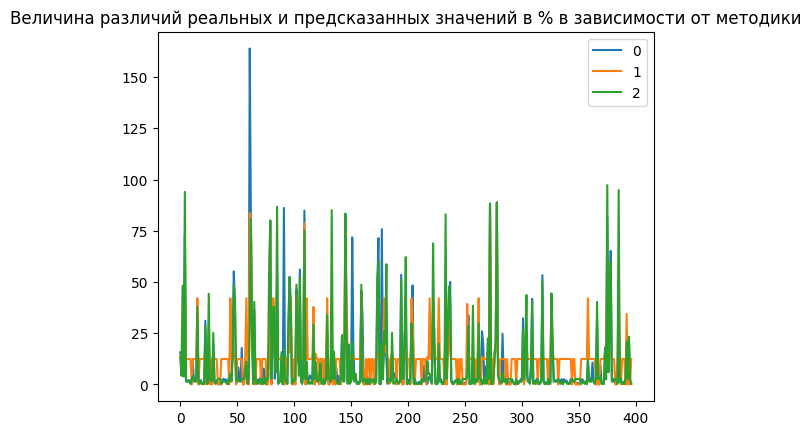

,method,mae,r_2,mse,mean_diff(%),mean_val_score
0,GradientBoostingRegressor(),0.200343,0.942338,0.614275,[9.718707363477304],0.946340
1,"RandomForestRegressor(max_depth=3, random_stat...",0.242066,0.943070,0.606483,[13.70682237850309],0.945854
2,"XGBRegressor(base_score=None, booster=None, ca...",0.249966,0.925820,0.790246,[9.757288346153393],0.946744


In [ ]:
# Используем три алгоритма ML:
l=[GradientBoostingRegressor(), RandomForestRegressor(max_depth=3, random_state=0), xg.XGBRegressor(objective ='reg:linear', n_estimators = 10, seed = 123)]
ml_method_estim(l, x_train, x_test, y_train, y_test, plot=True)